In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.circuit.library import XGate, YGate, ZGate, UnitaryGate
import numpy as np
import random

In [7]:
high_fidelity_gates = []
for gate in [XGate(), YGate(), ZGate()]: 
    high_fidelity_gates.append(np.array(gate))
gate_names = ['x', 'y', 'z']

def draw(circuit): 
    from qiskit import transpile

    scheduled = transpile(
        circuit, 
        optimization_level = 0, 
        instruction_durations = InstructionDurations(), 
        scheduling_method = 'alap'
    )

    return display(timeline_drawer(scheduled))

In [35]:
def is_identity(matrix, tolerance = 1e-6):
    identity_matrix = np.eye(matrix.shape[0])

    if matrix[0,0] == 0: 
        return False
    
    normalized_matrix = matrix / matrix[0, 0]

    return np.allclose(normalized_matrix, identity_matrix, atol=tolerance)

def sequence_product(sequence): 
    product = np.eye(sequence[0].shape[0])
    
    for matrix in sequence: 
        product = product.dot(matrix)

    return product 

def generate_sequence(gate_list, gate_names, length): 
    sequence = []
    string_sequence = [] 

    while len(sequence) < length: 
        subsequence = []
        matrix_idxs = [random.randint(0, len(gate_list) -1) for j in range(random.choice([2, 4]))]
        for idx in matrix_idxs: 
            subsequence.append(gate_list[idx])

        if is_identity(sequence_product(subsequence)): 
            sequence.extend(subsequence)

    for i in sequence: 
        for j in range(len(gate_list)):
            if np.allclose(i, gate_list[j], atol = 1e-6): 
                string_sequence.append(gate_names[j])
        
    return sequence, string_sequence

sequence, string_sequence = generate_sequence(high_fidelity_gates, 
                                              gate_names, 
                                              10)

In [3]:
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule, DynamicalDecoupling
from qiskit.visualization import timeline_drawer

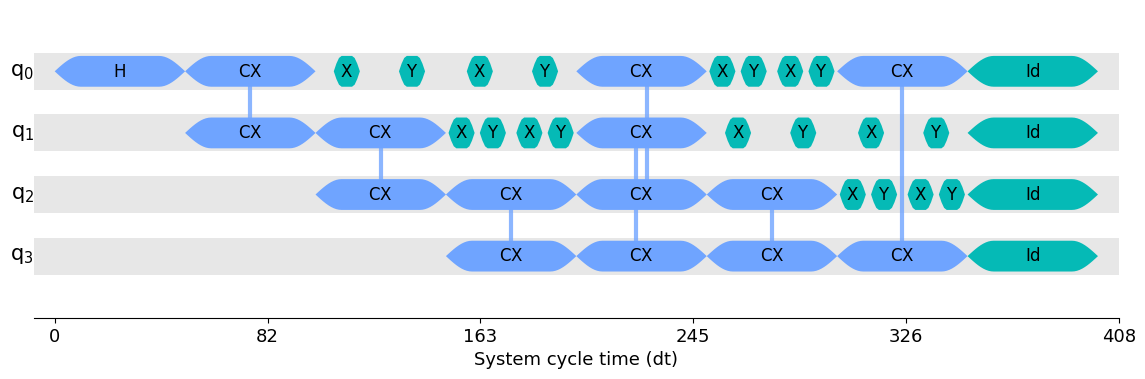

Gate: h, Qubits: [0], Duration: 50 
Gate: delay, Qubits: [1], Duration: 50 
Gate: cx, Qubits: [0, 1], Duration: 50 
Gate: delay, Qubits: [0], Duration: 7 
Gate: x, Qubits: [0], Duration: 10 
Gate: delay, Qubits: [0], Duration: 15 
Gate: y, Qubits: [0], Duration: 10 
Gate: delay, Qubits: [0], Duration: 16 
Gate: x, Qubits: [0], Duration: 10 
Gate: delay, Qubits: [0], Duration: 15 
Gate: y, Qubits: [0], Duration: 10 
Gate: delay, Qubits: [0], Duration: 7 
Gate: delay, Qubits: [2], Duration: 100 
Gate: cx, Qubits: [1, 2], Duration: 50 
Gate: delay, Qubits: [1], Duration: 1 
Gate: x, Qubits: [1], Duration: 10 
Gate: delay, Qubits: [1], Duration: 2 
Gate: y, Qubits: [1], Duration: 10 
Gate: delay, Qubits: [1], Duration: 4 
Gate: x, Qubits: [1], Duration: 10 
Gate: delay, Qubits: [1], Duration: 2 
Gate: y, Qubits: [1], Duration: 10 
Gate: delay, Qubits: [1], Duration: 1 
Gate: delay, Qubits: [3], Duration: 150 
Gate: cx, Qubits: [2, 3], Duration: 50 
Gate: cx, Qubits: [0, 2], Duration: 50 
G

In [51]:
tc = QuantumCircuit(4)
tc.h(0)
tc.cx(0, 1)
tc.cx(1, 2)
tc.cx(2, 3)
tc.cx(3, 1)
tc.cx(0, 2)
tc.cx(2, 3)
tc.cx(0, 3)
tc.id(range(0, tc.num_qubits))


gate_timings = []

for instruction in tc.data:
    inst = instruction.operation
    qubits = [tc.find_bit(qubit).index for qubit in instruction.qubits]  # Correct way to get qubit indices
    
    start_time = instruction.operation.start_time if hasattr(inst, 'start_time') else None
    duration = instruction.operation.duration if hasattr(inst, 'duration') else None

    gate_timings.append({
        'gate': inst.name,
        'qubits': qubits,
        'start_time': start_time,
        'duration': duration,
        'end_time': start_time + duration if start_time is not None and duration is not None else None
    })

durations_list = []
for timing in gate_timings:
    durations_list.append((timing['gate'], timing['qubits'], 50))

sequence = [XGate(), YGate(), XGate(), YGate()]

durations_list.append(('x', None, 10))
durations_list.append(('y', None, 10))

durations = InstructionDurations( 
    durations_list
)

dd_sequence = []
for i in range(len(sequence)): 
    for j in range(len(high_fidelity_gates)): 
        if np.allclose(Operator(sequence[i]), high_fidelity_gates[j], atol = 1e-6): 
            unitary_gate = UnitaryGate(high_fidelity_gates[j])
            unitary_gate.name = gate_names[j]
            dd_sequence.append(unitary_gate)

pm = PassManager(
    [
        ALAPSchedule(durations),
        DynamicalDecoupling(durations, dd_sequence)
    ]
)

tc_f = pm.run(tc)
draw(tc_f)

gate_timings = []
for instruction in tc_f.data:
    inst = instruction.operation
    qubits = [tc.find_bit(qubit).index for qubit in instruction.qubits]  # Correct way to get qubit indices
    
    duration = instruction.operation.duration if hasattr(inst, 'duration') else None

    if duration:
        gate_timings.append({
            'gate': inst.name,
            'qubits': qubits,
            'start_time': start_time,
            'duration': duration,
            'end_time': start_time + duration if start_time is not None and duration is not None else None
        })


for timing in gate_timings:
    print(f"Gate: {timing['gate']}, Qubits: {timing['qubits']}, "
          f"Duration: {timing['duration']} ")
    
print(gate_timings)


In [46]:
def calculate_intervals_with_delays(gate_timings, qubit):
    """
    Calculate time intervals between gates on a specific qubit, considering delay gates as the intervals.
    
    Args:
        gate_timings (list): List of timing dictionaries containing gate, qubits, start_time, and duration.
        qubit (int): Index of the qubit to analyze.

    Returns:
        intervals (list): List of intervals between gates, merging delay durations as intervals.
    """
    # Filter gates for the specified qubit and sort them in order of appearance
    timings = [t for t in gate_timings if qubit in t['qubits']]
    intervals = []

    i = 0
    while i < len(timings) - 1:
        curr_gate = timings[i]
        next_gate = timings[i + 1]

        # Check if the next gate is a delay; skip it as a gate and treat its duration as the interval
        if next_gate['gate'] == 'delay' and qubit in next_gate['qubits']:
            # Add the delay duration as the interval between the current and the following gate
            delay_duration = next_gate['duration']

            # Move to the gate after the delay
            if i + 2 < len(timings):
                next_gate_after_delay = timings[i + 2]
                intervals.append({
                    'between': (curr_gate['gate'], next_gate_after_delay['gate']),
                    'interval': delay_duration
                })
                i += 2  # Skip the delay gate and go to the next actual gate
            else:
                break  # Exit if the delay is the last in the sequence

        else:
            # If there's no delay, move to the next without adding an interval
            i += 1

    return intervals


# Example usage for qubit 0
qubit_0_intervals = calculate_intervals_with_delays(gate_timings, 0)
print("\nTime intervals between gates for qubit 0:")
for interval in qubit_0_intervals:
    print(interval)

# Repeat as needed for other qubits
qubit_1_intervals = calculate_intervals_with_delays(gate_timings, 1)
print("\nTime intervals between gates for qubit 1:")
for interval in qubit_1_intervals:
    print(interval)

qubit_2_intervals = calculate_intervals_with_delays(gate_timings, 2)
print("\nTime intervals between gates for qubit 2:")
for interval in qubit_2_intervals:
    print(interval)

qubit_3_intervals = calculate_intervals_with_delays(gate_timings, 3)
print("\nTime intervals between gates for qubit 3:")
for interval in qubit_3_intervals:
    print(interval)


Time intervals between gates for qubit 0:
{'between': ('cx', 'x'), 'interval': 7}
{'between': ('x', 'y'), 'interval': 15}
{'between': ('y', 'x'), 'interval': 16}
{'between': ('x', 'y'), 'interval': 15}
{'between': ('y', 'cx'), 'interval': 7}
{'between': ('cx', 'x'), 'interval': 1}
{'between': ('x', 'y'), 'interval': 2}
{'between': ('y', 'x'), 'interval': 4}
{'between': ('x', 'y'), 'interval': 2}
{'between': ('y', 'cx'), 'interval': 1}

Time intervals between gates for qubit 1:
{'between': ('cx', 'x'), 'interval': 1}
{'between': ('x', 'y'), 'interval': 2}
{'between': ('y', 'x'), 'interval': 4}
{'between': ('x', 'y'), 'interval': 2}
{'between': ('y', 'cx'), 'interval': 1}
{'between': ('cx', 'x'), 'interval': 7}
{'between': ('x', 'y'), 'interval': 15}
{'between': ('y', 'x'), 'interval': 16}
{'between': ('x', 'y'), 'interval': 15}
{'between': ('y', 'id'), 'interval': 7}

Time intervals between gates for qubit 2:
{'between': ('cx', 'x'), 'interval': 1}
{'between': ('x', 'y'), 'interval': 2

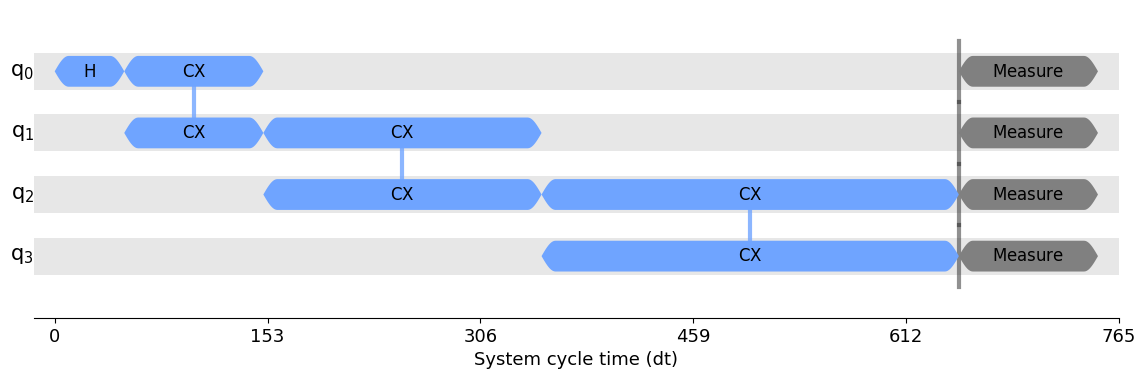

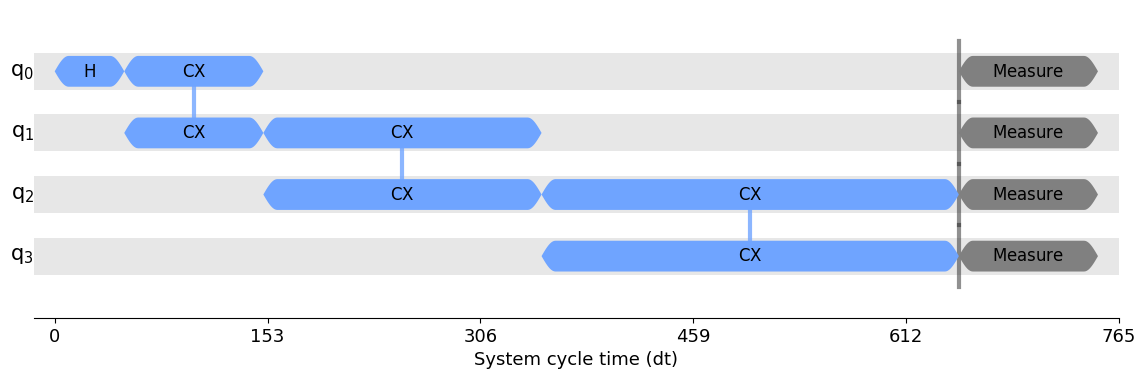

Gate: h, Qubits: [0], Duration: 50 
Gate: delay, Qubits: [1], Duration: 50 
Gate: cx, Qubits: [0, 1], Duration: 50 
Gate: delay, Qubits: [0], Duration: 150 
Gate: delay, Qubits: [2], Duration: 100 
Gate: cx, Qubits: [1, 2], Duration: 50 
Gate: delay, Qubits: [1], Duration: 50 
Gate: delay, Qubits: [3], Duration: 150 
Gate: cx, Qubits: [2, 3], Duration: 50 
Gate: delay, Qubits: [2], Duration: 50 
Gate: cx, Qubits: [3, 1], Duration: 50 
Gate: h, Qubits: [0], Duration: 50 
Gate: delay, Qubits: [1], Duration: 50 
Gate: cx, Qubits: [0, 1], Duration: 100 
Gate: delay, Qubits: [0], Duration: 500 
Gate: delay, Qubits: [2], Duration: 150 
Gate: cx, Qubits: [1, 2], Duration: 200 
Gate: delay, Qubits: [1], Duration: 300 
Gate: delay, Qubits: [3], Duration: 350 
Gate: cx, Qubits: [2, 3], Duration: 300 
Gate: barrier, Qubits: [0, 1, 2, 3], Duration: 0 
Gate: measure, Qubits: [0], Duration: 100 
Gate: measure, Qubits: [1], Duration: 100 
Gate: measure, Qubits: [2], Duration: 100 
Gate: measure, Qubi

In [37]:
circ = QuantumCircuit(4)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.cx(2, 3)
circ.measure_all()
durations = InstructionDurations( 
    [
        ('h', 0, 50), ('cx', [0, 1], 100), ('reset', None, 10), 
        ('cx', [1, 2], 200), ('cx', [2, 3], 300), 
        ('x', None, 1000), ('y', None, 1000), ('z', None, 1000), 
        ('measure', None, 100)
    ]
)

dd_sequence = []
for i in range(len(sequence)): 
    for j in range(len(high_fidelity_gates)): 
        if np.allclose(Operator(sequence[i]), high_fidelity_gates[j], atol = 1e-6): 
            unitary_gate = UnitaryGate(high_fidelity_gates[j])
            unitary_gate.name = gate_names[j]
            dd_sequence.append(unitary_gate)

pm = PassManager(
    [
        ALAPSchedule(durations),
        DynamicalDecoupling(durations, dd_sequence)
    ]
)

circ_dd = pm.run(circ)
draw(circ_dd)

scheduled_circuit = transpile(
    circ_dd,
    scheduling_method='alap',
    instruction_durations=durations,
    optimization_level=0
)

draw(scheduled_circuit)

for instruction in scheduled_circuit.data:
    inst = instruction.operation
    qubits = [circ_dd.find_bit(qubit).index for qubit in instruction.qubits]  # Correct way to get qubit indices
    
    # Extract the start time and duration of each gate
    start_time = instruction.operation.start_time if hasattr(inst, 'start_time') else None
    duration = instruction.operation.duration if hasattr(inst, 'duration') else None

    gate_timings.append({
        'gate': inst.name,
        'qubits': qubits,
        'start_time': start_time,
        'duration': duration,
        'end_time': start_time + duration if start_time is not None and duration is not None else None
    })

for timing in gate_timings: 
     print(f"Gate: {timing['gate']}, Qubits: {timing['qubits']}, "
          f"Duration: {timing['duration']} ")


Gate: h, Qubits: [0], Start Time: None, Duration: 50, End Time: None
Gate: delay, Qubits: [1], Start Time: None, Duration: 50, End Time: None
Gate: cx, Qubits: [0, 1], Start Time: None, Duration: 100, End Time: None
Gate: delay, Qubits: [0], Start Time: None, Duration: 500, End Time: None
Gate: delay, Qubits: [2], Start Time: None, Duration: 150, End Time: None
Gate: cx, Qubits: [1, 2], Start Time: None, Duration: 200, End Time: None
Gate: delay, Qubits: [1], Start Time: None, Duration: 300, End Time: None
Gate: delay, Qubits: [3], Start Time: None, Duration: 350, End Time: None
Gate: cx, Qubits: [2, 3], Start Time: None, Duration: 300, End Time: None
Gate: barrier, Qubits: [0, 1, 2, 3], Start Time: None, Duration: 0, End Time: None
Gate: measure, Qubits: [0], Start Time: None, Duration: 100, End Time: None
Gate: measure, Qubits: [1], Start Time: None, Duration: 100, End Time: None
Gate: measure, Qubits: [2], Start Time: None, Duration: 100, End Time: None
Gate: measure, Qubits: [3], S

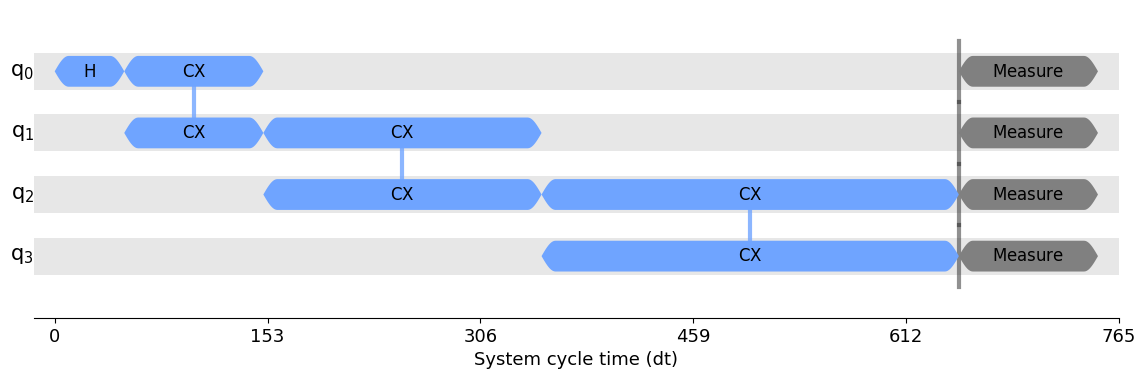

In [25]:
gate_timings = []

# Use the scheduled instructions from the scheduled circuit
for instruction in circ_dd.data:
    inst = instruction.operation
    qubits = [circ_dd.find_bit(qubit).index for qubit in instruction.qubits]  # Correct way to get qubit indices
    
    # Extract the start time and duration of each gate
    start_time = instruction.operation.start_time if hasattr(inst, 'start_time') else None
    duration = instruction.operation.duration if hasattr(inst, 'duration') else None

    gate_timings.append({
        'gate': inst.name,
        'qubits': qubits,
        'start_time': start_time,
        'duration': duration,
        'end_time': start_time + duration if start_time is not None and duration is not None else None
    })

# Print the extracted gate timing information
for timing in gate_timings:
    print(f"Gate: {timing['gate']}, Qubits: {timing['qubits']}, "
          f"Start Time: {timing['start_time']}, Duration: {timing['duration']}, "
          f"End Time: {timing['end_time']}")
    

scheduled_circuit = transpile(
    circ_dd,
    scheduling_method='alap',
    instruction_durations=durations,
    optimization_level=0
)

draw(scheduled_circuit)


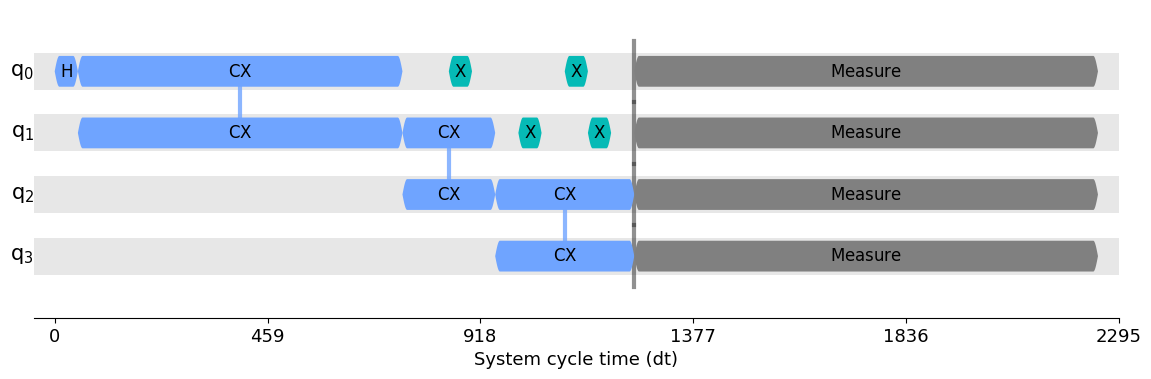

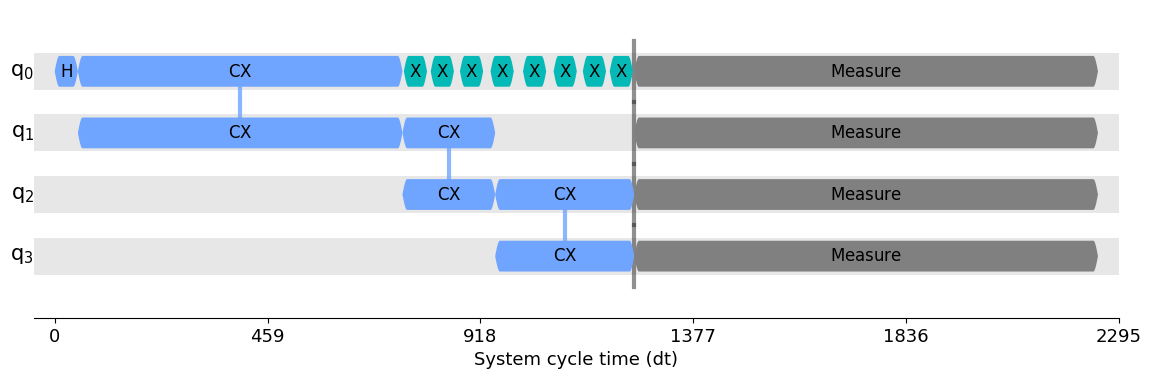

In [102]:
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule, DynamicalDecoupling
from qiskit.visualization import timeline_drawer
 
# Because the legacy passes do not propagate the scheduling information correctly, it is
# necessary to run a no-op "re-schedule" before the output circuits can be drawn.
def draw(circuit):
    from qiskit import transpile
 
    scheduled = transpile(
        circuit,
        optimization_level=0,
        instruction_durations=InstructionDurations(),
        scheduling_method="alap",
    )
    return timeline_drawer(scheduled)
 
circ = QuantumCircuit(4)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.cx(2, 3)
circ.measure_all()
durations = InstructionDurations(
    [("h", 0, 50), ("cx", [0, 1], 700), ("reset", None, 10),
     ("cx", [1, 2], 200), ("cx", [2, 3], 300),
     ("x", None, 50), ("measure", None, 1000)]
)
# balanced X-X sequence on all qubits
dd_sequence = [XGate(), XGate()]
pm = PassManager([ALAPSchedule(durations),
                  DynamicalDecoupling(durations, dd_sequence)])
circ_dd = pm.run(circ)
display(draw(circ_dd))
 
# Uhrig sequence on qubit 0
n = 8
dd_sequence = [XGate()] * n
def uhrig_pulse_location(k):
    return np.sin(np.pi * (k + 1) / (2 * n + 2)) ** 2
spacing = []
for k in range(n):
    spacing.append(uhrig_pulse_location(k) - sum(spacing))
spacing.append(1 - sum(spacing))
pm = PassManager(
    [
        ALAPSchedule(durations),
        DynamicalDecoupling(durations, dd_sequence, qubits=[0], spacing=spacing),
    ]
)
circ_dd = pm.run(circ)
draw(circ_dd)